# Try out notebook for TOME vault web scraper

## Observations
- base url of page list: https://te4.org/characters-vault
- url of page n: https://te4.org/characters-vault?page=n
- links of character pages can be extracted from page list
- talents need to be extracted
- somehow extract talents that need to be unlocked?
- stats too
- gear too?
- stats too?
- inscriptions too?
- Only selected permadeth = 'roguelike': https://te4.org/characters-vault?tag_name=&tag_level_min=&tag_level_max=&tag_permadeath%5B%5D=66#
- only selected difficulty = 'insane': https://te4.org/characters-vault?tag_name=&tag_level_min=&tag_level_max=&tag_difficulty%5B%5D=36#
- only selected race = 'cornac': https://te4.org/characters-vault?tag_name=&tag_level_min=&tag_level_max=&tag_race%5B%5D=8#
- only selected class = 'archmage': https://te4.org/characters-vault?tag_name=&tag_level_min=&tag_level_max=&tag_class%5B%5D=7#
- only selected campagin = 'majeyal': https://te4.org/characters-vault?tag_name=&tag_level_min=&tag_level_max=&tag_campaign%5B%5D=2#
- only selected version = '1.7.6': https://te4.org/characters-vault?tag_name=&tag_level_min=&tag_level_max=&tag_game%5B%5D=1191241#
- Can't immediately see maximum number of pages
- should probably build in a way to cap the number of characters extracted
- should somehow solve the issue of chinese characters




In [13]:
# Load packages

from bs4 import BeautifulSoup
import requests
import pandas as pd
from collections import OrderedDict

### Extract all character links from a page

In [18]:
## Set up
base_url = "https://te4.org/characters-vault"

req = requests.get(base_url)
print(req)

soup = BeautifulSoup(req.text, 'html.parser')

## One character urls
char_url_html = soup.find("tr", {"class": "even"})
char_url = "https://te4.org/" + char_url_html.find_all("a")[1].get("href")
print(char_url)

## All character urls of page
char_url_html_list = soup.find_all("tr", {"class": "even"}) + soup.find_all("tr", {"class": "odd"})

char_url_list = set()

# Loop over all html
for url_html in char_url_html_list:
    char_url_list.add("https://te4.org/" + url_html.find_all("a")[1].get("href"))
    
print(char_url_list)

# Method that gets the character urls from a page
def get_char_urls_from_page(page_url=None, soup=None):
    
    # Set up BeautifulSoup if isn't given
    if not soup:
        req = requests.get(page_url)
        soup = BeautifulSoup(req.text, 'html.parser')
    
    # Extract the html elements that contain the urls
    char_url_html_list = soup.find_all("tr", {"class": "even"}) + soup.find_all("tr", {"class": "odd"})
    
    # Loop over those elements to get the character page urls
    char_url_list = set()
    for url_html in char_url_html_list:
        char_url_list.add("https://te4.org/" + url_html.find_all("a")[1].get("href"))
        
    # Return set
    return char_url_list

<Response [200]>
https://te4.org//characters/338500/tome/de9c496d-9a04-4d4c-9c3b-84f16f42a12c
{'https://te4.org//characters/313231/tome/dc6ba9cb-e212-4808-9b41-c1e58e764dc6', 'https://te4.org//characters/299006/tome/c43e30f8-f279-41e9-89a7-0603eec3bb62', 'https://te4.org//characters/338500/tome/de9c496d-9a04-4d4c-9c3b-84f16f42a12c', 'https://te4.org//characters/127155/tome/0d8329cb-b607-4a57-b29f-59fed3eb92c0', 'https://te4.org//characters/16818/tome/1068175a-20da-4d9c-b02f-2a763e01900c', 'https://te4.org//characters/218911/tome/dbacad1b-3e62-4324-87fb-94545856ac51', 'https://te4.org//characters/243124/tome/374e8620-429f-4015-b781-3cce3595c19c', 'https://te4.org//characters/278176/tome/459e1690-d37d-4ad1-81a7-e6c8ab4f8175', 'https://te4.org//characters/135195/tome/96e9df2d-5e06-4233-9097-343a99272b55', 'https://te4.org//characters/314970/tome/502b5083-5337-49db-8f0e-4a5a319c2148', 'https://te4.org//characters/339040/tome/d99a5b78-2ee0-46fe-9f21-05db24307e57', 'https://te4.org//characte

### Extract character urls from multiple pages, pages start at 0

In [20]:
base_url = "https://te4.org/characters-vault?tag_name=&tag_level_min=&tag_level_max=&tag_game%5B%5D=1191241&page=1"
empty_url = "https://te4.org/characters-vault?tag_name=&tag_level_min=&tag_level_max=&tag_winner=winner&tag_permadeath%5B%5D=66&tag_difficulty%5B%5D=36&tag_race%5B%5D=47&tag_class%5B%5D=104071&tag_game%5B%5D=1191241#"

# Skip if 'no characters available' shows up or url_limit is reached
req = requests.get(empty_url)

soup = BeautifulSoup(req.text, "html.parser")

check = soup.find("tr", {"class":"odd"})
if check.text == 'No characters available. ':
    print('no')
    
def empty_page(page_url=None, soup=None):
    if not soup:
        req = requests.get(page_url)
        soup = BeautifulSoup(req.text, 'html.parser')
        
    check = soup.find("tr", {"class":"odd"})
    if check.text == 'No characters available. ':
        return True
    else:
        return False
    
# Method that returns all the character urls, up to a maximum
def get_all_character_urls(base_url, max_urls = 100):
    print('Extracting character urls...')
    
    # Set up
    character_urls = set()
    page_number = 0
    
    while len(character_urls) <= max_urls:
        
        print(f'Now at {len(character_urls)} characters. Extracting characters from page {page_number}...')
        
        # Make current page url, get soup
        page_url = f"{base_url}&page={page_number}"
        
        req = requests.get(page_url)
        soup = BeautifulSoup(req.text, "html.parser")
        
        # Break if the page is empty
        if empty_page(soup=soup):
            print(f"Page {page_number} is empty. Ending...")
            break
        
        # Get the character urls from the current page
        character_urls = character_urls | get_char_urls_from_page(soup=soup) # Take union of the two sets
        
        # Update the page number
        page_number += 1
        
    return character_urls
    
#urls = get_all_character_urls(base_url)


no


### Extracting info from character page

#### Try out

In [254]:
char_url = "https://te4.org/characters/259208/tome/bddd99b8-9594-44d2-a0ba-ec743bafabfa"

req = requests.get(char_url)

soup = BeautifulSoup(req.text, 'html.parser')

### Name of the character (and the creator)
full_name = soup.find("div", {"id": "title-container"}).text

### Info from tables at the top
char_tables = soup.find_all("div", {"class": "charsheet"})

## Character table (Maybe change to dictionary later)
character_table = char_tables[0]
character_table_entries = character_table.find_all("tr")

# Game & Version
game_line = character_table_entries[0]
game_text = game_line.find_all("td")[1].text
game_text_split = game_text.split(' ')

version = list.pop(game_text_split)
game = ' '.join(game_text_split)

# Difficulty and permadeatch
mode_line = character_table_entries[1]
mode_text = mode_line.find_all("td")[1].text
mode_text_split = mode_text.split(' ')
difficulty = mode_text_split[0]
permadeath = mode_text_split[1]
print(difficulty, permadeath)
# Sex
sex_line = character_table_entries[2]
sex = sex_line.find_all("td")[1].text

# Race
race_line = character_table_entries[3]
race = race_line.find_all("td")[1].text

# Class
class_line = character_table_entries[4]
class_ = class_line.find_all("td")[1].text

# Level
level_line = character_table_entries[5]
level = level_line.find_all("td")[1].text

## Stats
stats_table = char_tables[1]
stats_table_entries = stats_table.find_all("tr")

stats = {}
for row in stats_table_entries:
    stat = row.find_all("td")[0].text
    value = row.find_all("td")[1].text
    stats[stat] = value
    
print(stats)
    
## Infusions
infusions_table = char_tables[14]
infusions_html = infusions_table.find_all("td", {"class": "qtip-link"})

infusions = list()
for infusion in infusions_html:
    infusion.find('div').decompose()
    infusions.append(infusion.text)
    
print(infusions)

## Class and Generic Talents
from collections import OrderedDict


        
class_talents_table = char_tables[15]
generic_talents_table = char_tables[16]

class_talents = get_trees(class_talents_table)
generic_talents = get_trees(generic_talents_table)

print(class_talents)
print(generic_talents)

# Prodigies
prodigy_table = char_tables[17]
print(prodigy_table.find("h4"))
entries = prodigy_table.find_all('tr')

prodigies = list()
for line_html in entries:
    line_html.find('div').decompose()
    prodigies.append(line_html.find('li').text)
    
print(prodigies)





Items Vault
{'Strength': '51 (base 9)', 'Dexterity': '46 (base 30)', 'Constitution': '138 (base 60)', 'Magic': '136 (base 62)', 'Willpower': '23 (base 9)', 'Cunning': '82 (base 60)'}
['Infusion: Movement', 'Rune: Mirror Image', 'Infusion: Wild Growth', 'Rune: Dissipation', 'Rune: Shatter Afflictions']
OrderedDict([('Celestial / Circles', OrderedDict([('Circle of Shifting Shadows', 5), ('Circle of Sanctity', 5), ('Circle of Warding', 3), ('Celestial Surge', 4)])), ('Celestial / Star fury', OrderedDict([('Moonlight Ray', 5), ('Shadow Blast', 5), ('Twilight Surge', 5), ('Starfall', 1)])), ('Celestial / Eclipse', OrderedDict([('Blood Red Moon', 5), ('Totality', 4), ('Corona', 1), ('Darkest Light', 5)])), ('Celestial / Sunlight', OrderedDict([('Searing Light', 5), ('Sun Flare', 5), ('Firebeam', 0), ('Sunburst', 0)])), ('Celestial / Twilight', OrderedDict([('Twilight', 1), ('Jumpgate', 5), ('Mind Blast', 1), ('Shadow Simulacrum', 5)]))])
OrderedDict([('Race / Dwarf', OrderedDict([('Resilienc

#### Methods

In [12]:

# Method that gets a dictionary containing the character table titles and their indices
def get_table_dict(tables):
    
    dict = {}
    
    dict['Prodigies'] = 17
    
    for index, table in enumerate(tables):
        try:
            name = table.find('h4').text
        
            if 'Inscriptions' in name.split(' '):
                name = 'Inscriptions'
        
            dict[name] = index
        except:
            pass
        
    return dict


# Method that extracts the information from the generic and class talent tables
def get_trees(table):
    
    try:
        lines_html = table.find_all("tr")
        
        talents = OrderedDict()
        line_num = 0
        extra = 0

        # Loop over all lines
        for line in lines_html:
            
            # Every fifth line stands for a tree
            if line_num % (5 + extra) == 0:
                line_num = 0
                elements = line.find_all('td')
                tree = elements[0].text

                tree_dict = OrderedDict()
                
                if tree == 'Technique / Combat training':
                    extra = 2 
                else: 
                    extra = 0
            
            # The other lines stand for skills in a tree
            else:
                line.find('div').decompose()
                talent = line.find('li').text
                level = line.find_all('td')[-1].text
                level_int = int(level[0])
                tree_dict[talent] = level_int
                talents[tree] = tree_dict

            line_num += 1
            
        return talents
    
    except Exception as e:
        print('Something went wrong extracting the skill tree (Probably a non-english character)')
        print(e)
        return OrderedDict()

# Method that puts the relevant data of a character in a dictionary
def get_character_dictionary(char_url):
    
    print(f'Beginning to extract {char_url}...')
    
    try:
    
        # Set up BeautifulSoup
        req = requests.get(char_url)
        soup = BeautifulSoup(req.text, 'html.parser')

        ### Name of the character (and the creator)
        full_name = soup.find("div", {"id": "title-container"}).text

        ### Info from tables at the top
        char_tables = soup.find_all("div", {"class": "charsheet"})
        
        tables_dict = get_table_dict(char_tables)

        ## Character table (Maybe change to dictionary later)
        character_index = tables_dict['Character']
        character_table = char_tables[character_index]
        character_table_entries = character_table.find_all("tr")

        # Game & Version
        game_line = character_table_entries[0]
        game_text = game_line.find_all("td")[1].text
        game_text_split = game_text.split(' ')

        version = list.pop(game_text_split)
        game = ' '.join(game_text_split)

        # Difficulty and permadeatch
        mode_line = character_table_entries[3]
        mode_text = mode_line.find_all("td")[1].text
        mode_text_split = mode_text.split(' ')
        difficulty = mode_text_split[0]
        permadeath = mode_text_split[1]

        # Sex
        sex_line = character_table_entries[4]
        sex = sex_line.find_all("td")[1].text

        # Race
        race_line = character_table_entries[5]
        race = race_line.find_all("td")[1].text

        # Class
        class_line = character_table_entries[6]
        class_ = class_line.find_all("td")[1].text

        # Level
        level_line = character_table_entries[7]
        level = level_line.find_all("td")[1].text
        
        # Size
        size_line = character_table_entries[8]
        size = size_line.find_all("td")[1].text
        
        # English
        if size in ['tiny', 'small', 'medium', 'big', 'huge', 'gargantuan']:
            english = True
        else: 
            english = False

        ## Stats
        stats_index = tables_dict['Primary Stats']
        stats_table = char_tables[stats_index]
        stats_table_entries = stats_table.find_all("tr")

        stats = {}
        for row in stats_table_entries:
            stat = row.find_all("td")[0].text
            value = row.find_all("td")[1].text
            stats[stat] = value
            
        ## Inscriptions
        inscriptions_index = tables_dict['Inscriptions']
        inscriptions_table = char_tables[inscriptions_index]
        inscriptions_html = inscriptions_table.find_all("td", {"class": "qtip-link"})

        inscriptions = list()
        for inscription in inscriptions_html:
            inscription.find('div').decompose()
            inscriptions.append(inscription.text)

        ## Class and Generic Talents
        
        class_talents_index = tables_dict["Class Talents"]
        generic_talents_index = tables_dict["Generic Talents"]
        
        class_talents_table = char_tables[class_talents_index]
        generic_talents_table = char_tables[generic_talents_index]
        
        class_talents = get_trees(class_talents_table)
        generic_talents = get_trees(generic_talents_table)

        ## Prodigies
        prodigies = list()
        
        prodigy_index = tables_dict['Prodigies']
        prodigy_table = char_tables[prodigy_index]
        
        if prodigy_table.find("h4").text == "Prodigies":
            
            entries = prodigy_table.find_all('tr')
            
            for line_html in entries:
                line_html.find('div').decompose()
                prodigies.append(line_html.find('li').text)
            
        char_dictionary = {'name': full_name,
                        'race': race,
                        'class': class_,
                        'sex': sex,
                        'level': level,
                        'size': size,
                        'english': english,
                        'stats': stats,
                        'inscriptions': inscriptions,
                        'class talents': class_talents,
                        'generic talents': generic_talents,
                        'prodigies': prodigies,
                        'game': game,
                        'version': version,
                        'difficulty': difficulty,
                        'permadeath': permadeath}
        
        return char_dictionary
    except Exception as e:
        print('Something went wrong with this character')
        print(e)
        return {'class talents': OrderedDict(), 'generic talents': OrderedDict()}
    

### Filter using search link

#### Automatically get the race codes

In [ ]:
race_codes = {}

base_url = "https://te4.org/characters-vault?tag_name=&tag_level_min=&tag_level_max="

for i in range(1, 100): 
    tag = f'&tag_race%5B%5D={i}#'
    url = base_url + tag
    
    char_link = get_all_character_urls(url, max_urls=1)
    
    if char_link:
        
        try:
            char = get_character_dictionary(list(char_link)[0])
            race_codes[char['race']] = str(i)
        except: 
            print('something went wrong with this character, probably a very janky character') 

#### Automatically get class codes

In [257]:
base_url = "https://te4.org/characters-vault?tag_name=&tag_level_min=&tag_level_max="

class_codes = {}

for i in range(1, 200): 
    tag = f'&tag_class%5B%5D={i}#'
    url = base_url + tag
    
    char_link = get_all_character_urls(url, max_urls=1)
    
    if char_link:
        
        try:
            char = get_character_dictionary(list(char_link)[0])
            class_codes[char['class']] = str(i)
        except: 
            print('something went wrong with this character, probably a very janky character') 

Extracting character urls...
Extracting characters from page 0...
Page 0 is empty. Ending...
Extracting character urls...
Extracting characters from page 0...
Page 0 is empty. Ending...
Extracting character urls...
Extracting characters from page 0...
Page 0 is empty. Ending...
Extracting character urls...
Extracting characters from page 0...
Beginning to extract https://te4.org//characters/33258/tome/41a0f4bc-7165-4f0e-8f78-7a2a284e5b02...
{'Prodigies': 17, 'Character': 0, 'Primary Stats': 1, 'Resources': 2, 'Speed': 3, 'Vision': 4, 'Offense: Mainhand': 5, 'Offense: Spell': 6, 'Offense: Mind': 7, 'Defense: Base': 8, 'Defense: Immunities': 9, 'Inscriptions (3/3)': 10, 'Class Talents': 11, 'Generic Talents': 12, 'Effects': 13, 'Quests': 14, 'Equipment': 15, 'Inventory': 16, 'Achievements': 17, 'Log': 18}
Extracting character urls...
Extracting characters from page 0...
Page 0 is empty. Ending...
Extracting character urls...
Extracting characters from page 0...
Page 0 is empty. Ending...

KeyboardInterrupt: 

#### Filtering

In [2]:
import filter_codes
from collections import defaultdict
from dataclasses import dataclass

# Tag order: name, minlevel, maxlevel, dead, winner, permadeath, difficulty, race, class, campaign, version, official addons
base_url = 'https://te4.org/characters-vault?tag_name=&tag_level_min=&tag_level_max='

@dataclass(frozen=False)
class CharFilter:
    name: str = ''
    minlevel: str = ''
    maxlevel: str = ''
    dead: bool = False
    winner: bool = False
    permadeath: str = ''
    difficulty: str = ''
    race: str = ''
    char_class: str = ''
    campaign: str = ''
    version: str = ''
    only_official_addons: bool = False
    max_urls: int = 100
    
    # Method that creates the filtered base url
    def create_url(self) -> str:
        import filter_codes
        
        tags = list()
        
        if self.name != '':
            tags.append(f'tag_name={self.name}')
        
        if self.minlevel != '':
            tags.append(f'tag_level_min={self.minlevel}')
            
        if self.maxlevel != '':
            tags.append(f'tag_level_max={self.maxlevel}')
        
        if self.dead:
            tags.append('tag_dead=dead')
            
        if self.winner:
            tags.append('tag_winner=winner')
            
        if self.permadeath != '':
            permadeath_code = filter_codes.permadeath_codes[self.permadeath]
            tags.append(f'tag_permadeath%5B%5D={permadeath_code}')
            
        if self.difficulty != '':
            difficulty_code = filter_codes.difficulty_codes[self.difficulty]
            tags.append(f'tag_difficulty%5B%5D={difficulty_code}')
            
        if self.race != '':
            race_code = filter_codes.race_codes[self.race]
            tags.append(f'tag_race%5B%5D={race_code}')
            
        if self.char_class != '':
            class_code = filter_codes.class_codes[self.char_class]
            tags.append(f'tag_class%5B%5D={class_code}')
            
        if self.campaign != '':
            campagin_code = filter_codes.campaign_codes[self.campaign]
            tags.append(f'tag_campagin%5B%5D={campagin_code}')
            
        if self.version != '':
            version_code = filter_codes.version_codes[self.version]
            tags.append(f'tag_game%5B%5D={version_code}')
            
        if self.only_official_addons:
            tags.append('tag_official_addons=1')
            
        base_url = 'https://te4.org/characters-vault?'
        filter_tags = '&'.join(tags)
        url = base_url + filter_tags
        
        return url
    
    # Method that extracts the filtered characters
    def get_characters(self):
        
        # Get url
        filtered_url = self.create_url()
        
        # Get charachter links
        char_urls = get_all_character_urls(base_url = filtered_url, max_urls = self.max_urls)
        
        # Extract characters
        characters = list()
        for url in char_urls:
    
            char = get_character_dictionary(url)
    
            # Filter out non-english characters
            if not char['class talents'] == OrderedDict() and not char['generic talents'] == OrderedDict():
                characters.append(char)
                
        return characters
    

            
            
        
        

#### Not working multifilter

In [ ]:
def default_names():
    return ['']

def default_permadeaths():
    return ['']

def default_difficulties():
    return ['']

def default_races():
    return ['']

def default_char_classes():
    return ['']

def default_campaigns():
    return ['']

def default_versions():
    return ['']    

from dataclasses import field

@dataclass
class multiFilter():
    names: list[str] = field(default_factory=default_names)
    minlevel: str = ''
    maxlevel: str = ''
    dead: bool = False
    winner: bool = False
    permadeaths: list[str] = field(default_factory=default_permadeaths)
    difficulties: list[str] = field(default_factory=default_difficulties)
    races: list[str] = field(default_factory=default_races)
    char_classes: list[str] = field(default_factory=default_char_classes)
    campaigns: list[str] = field(default_factory=default_campaigns)
    versions: list[str] = field(default_factory=default_versions)
    only_official_addons: bool = False
    max_urls: int = 100
    
    # Method that returns all the corresponding filters
    def get_filters(self) -> list:
        
        print('Setting up a filter')
        
        char_filters = list()
        
        for name in self.names:
            for permadeath in self.permadeaths:
                for difficulty in self.difficulties:
                    for char_class in self.char_classes:
                        for campaign in self.campaigns:
                            for version in self.versions:
            
                                filter = charFilter()
                                filter.minlevel = self.minlevel
                                filter.maxlevel = self.maxlevel
                                filter.dead = self.dead
                                filter.winner = self.winner
                                filter.only_official_addons = self.only_official_addons
                                
                                filter.name = name
                                filter.permadeath = permadeath
                                filter.difficulty = difficulty
                                filter.char_class = char_class
                                filter.campaign = campaign
                                filter.version = version
                            
                                char_filters.extend(filter)
            
        return char_filters
    
    # Method that returns the characters of the filters
    def get_characters(self) -> list:
        
        # Get the filters
        filters = self.get_filters()
        print(filters)
        
        characters = list()
        
        # Loop over all filters
        for filter in filters:
            
            # Set the maximum number of urls
            filter.max_urls = self.max_urls - len(characters)
            
            # Extract the characters and add
            characters_filter = filter.get_characters()
            characters.extend(characters_filter)
        
        # Return the character dictionaries
        return characters

### Put together

In [3]:
# Set up filter
char_filter = CharFilter()
char_filter.winner = True
char_filter.difficulty = 'insane'
char_filter.char_class = 'Archmage'
char_filter.max_urls = 1000

characters = list()

versions = ['1.7.6', '1.7.5', '1.7.4', '1.7.3', '1.7.2', '1.7.1', '1.7.0']

for version in versions:
    
    char_filter.version = version
    characters.extend(char_filter.get_characters())

import pickle

with open(f'test.pkl', 'wb') as fp:
    pickle.dump(characters, fp)



NameError: name 'get_all_character_urls' is not defined

In [8]:
# Load saved characters
import pickle
def read_from_pickle(path):
    with open(path, 'rb') as file:
        try:
            while True:
                yield pickle.load(file)
        except EOFError:
            pass
        
characters = read_from_pickle('test.pkl')
print(characters)

<generator object read_from_pickle at 0x0000025BFF8B6B60>


### Analaysis


In [22]:
# Load character data

# Somehow turn the class talents, generic talents, prodigies and infusions into variables

# Remove empty characters
characters_cleaned = list()

for char in characters:
    if not char['class talents'] == None and char['english']:
        characters_cleaned.append(char)

#### Prodigies

In [24]:
prodigies_list = list()

for i, char in enumerate(characters_cleaned):
    prodigies = char['prodigies']
    prodigies_list.append(prodigies)
    
prodigies_list

data = []

for i, char in enumerate(characters_cleaned):
    dict = {"Prodigies": char['prodigies']}
    data.append(dict)
    
# Create dataframe
df = pd.DataFrame(data)

total_prodigies = []
for prods in prodigies_list:
    total_prodigies.extend(prods)
    
unique_prodigies = list(set(total_prodigies))

# Create binary variables for each prodigy
for prodigy in unique_prodigies:
    df[prodigy] = df['Prodigies'].apply(lambda x: int(prodigy in x))


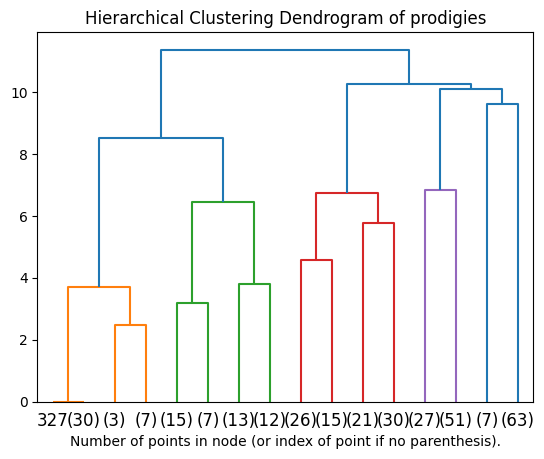

In [25]:
column_sums = df.iloc[:, 2:].sum()
sorted_sums = column_sums.sort_values(ascending=False)
# print(sorted_sums)

from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import numpy as np

df.head()

df_adj = pd.DataFrame(df.iloc[:, 2:])

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
    
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df_adj.to_numpy())
plt.title("Hierarchical Clustering Dendrogram of prodigies")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [293]:
num_clusters = 2

model = AgglomerativeClustering(n_clusters=num_clusters)

model = model.fit(df_adj.to_numpy())

df_cluster_labels = df.iloc[:, :2]
df_cluster_labels['Cluster'] = model.labels_


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

df_adj['Cluster'] = model.labels_

cluster1_sum = df_adj[df_adj['Cluster'] == 0].sum()
sorted_sums1 = cluster1_sum.sort_values(ascending=False)

cluster2_sum = df_adj[df_adj['Cluster'] == 1].sum()
sorted_sums2 = cluster2_sum.sort_values(ascending=False)

#print(sorted_sums1)

print(sorted_sums2)

Cluster                                                   165
Ethereal Form                                             120
Aether Permeation                                          63
#LIGHT_STEEL_BLUE#High Thaumaturgist (Class Evolution)     42
#LIGHT_STEEL_BLUE#Technomancer (Class Evolution)           41
Adept                                                      27
Master of Disasters                                        21
Meteoric Crash                                             18
Elemental Surge                                            11
Eye of the Tiger                                           10
Pain Enhancement System                                     7
Unbreakable Will                                            7
Spine of the World                                          6
Lucky Day                                                   6
Cauterize                                                   5
Arcane Might                                                4
Superpow

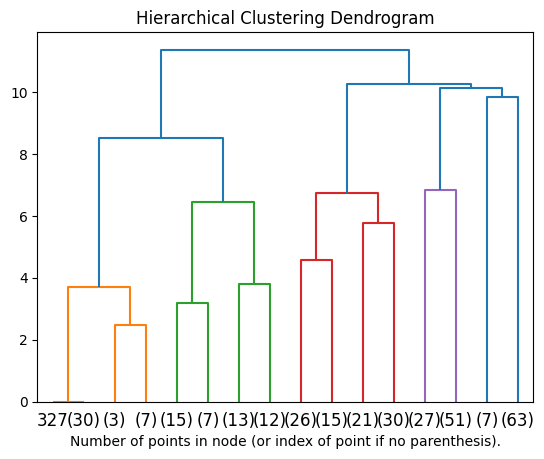

In [40]:

# Method that returns an encoded dataframe with regards to the prodigies
def get_encoded_prodigy_df(char_list):
    
    # Create basic dataframe
    data = []
    for char in char_list:
        dict = {"Prodigies": char['prodigies']}
        data.append(dict)
        
    df = pd.DataFrame(data)

    # Get unique prodigies
    total_prodigies = []
    for prods in prodigies_list:
        total_prodigies.extend(prods)
        
    unique_prodigies = list(set(total_prodigies))

    # Create binary variables for each prodigy
    for prodigy in unique_prodigies:
        df[prodigy] = df['Prodigies'].apply(lambda x: int(prodigy in x))
    
    # Drop first column
    df = df.iloc[: , 1:]
    
    return df

# Input list of characters, output dendogram, uses plot_dendrogram method from previous block
def print_dendrogram(encoded_df):

    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

    model = model.fit(encoded_df.to_numpy())
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram
    plot_dendrogram(model, truncate_mode="level", p=3)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

# Method that output the cluster model of the characters with regards to the prodigies
def get_cluster_model(encoded_df, num_clusters, model = None):
    
    if model == None:
        model = AgglomerativeClustering(n_clusters=num_clusters, compute_distances=True)

    model = model.fit(encoded_df.to_numpy())
    
    return model

prodigy_df = get_encoded_prodigy_df(characters_cleaned)
print_dendrogram(prodigy_df)
#get_encoded_prodigy_df(characters_cleaned)

#### Talents

In [301]:
# Class talents
print(list(characters_cleaned[0]['class talents'].keys()))

unique_trees = set()
unique_class_talents = set()

for char in characters_cleaned:
    
    # Update unique trees
    trees = set(char['class talents'].keys())
    unique_trees = unique_trees | trees # Take union
    
    # Update  unique talents
    talents = list()
    for tree in list(char['class talents'].values()):
        talents.extend(tree.keys())
        
    unique_class_talents = unique_class_talents | set(talents) # Take union
    
unique_trees = list(unique_trees)
print(unique_trees)
print(unique_class_talents)

# Encode from dictionary


    

['Spell / Meta', 'Spell / Temporal', 'Spell / Air', 'Spell / Thaumaturgy', 'Spell / Arcane', 'Spell / Phantasm', 'Spell / Earth', 'Spell / Fire', 'Spell / Water']
['Spell / Arcane', 'Spell / Earth', 'Spell / Fire', 'Spell / Galvanic technomancy', 'Spell / Wildfire', 'Spell / Ice', 'Spell / Terrene technomancy', 'Spell / Thaumaturgy', 'Spell / Aether', 'Spell / Meta', 'Spell / Phantasm', 'Spell / Storm', 'Spell / Stone', 'Spell / Air', 'Spell / Temporal', 'Spell / Water', 'Spell / Occult technomancy', 'Cunning / Tactical']
{'Stone Skin', 'Shatter', 'Time Prison', 'Stone Wall', 'Mirror Image', 'Lightning', 'Mudslide', 'Freeze', 'Micro Spiderbot', 'Reality Breach', 'Ramming Bot', 'Aether Breach', 'Thunderstorm', 'Flameshock', 'Shock', 'Burning Wake', 'Flame', 'Energy Alteration', 'Hurricane', 'Metaphasic Echoes', 'Spellcraft', 'Earthen Missiles', 'Crystalline Focus', 'Slipstream', 'Spiderbot Shield', 'Uttercold', 'Fireflash', 'Tempest', 'Galvanic Rod', 'Cleansing Flames', 'Essence of Spee

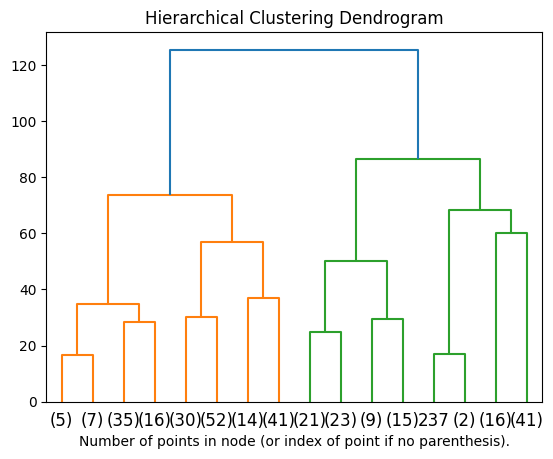

Cunning / Tactical              0.0
Spell / Fire                    1.0
Spell / Stone                   0.0
Spell / Meta                    1.0
Spell / Aether                  1.0
Spell / Phantasm                1.0
Spell / Air                     1.0
Spell / Storm                   0.0
Spell / Terrene technomancy     0.0
Spell / Temporal                1.0
Spell / Wildfire                0.0
Spell / Arcane                  1.0
Spell / Thaumaturgy             0.0
Spell / Earth                   1.0
Spell / Water                   1.0
Spell / Ice                     0.0
Spell / Galvanic technomancy    0.0
Spell / Occult technomancy      1.0
Set Up                          0.0
Wildfire                        0.0
Thunderstorm                    1.0
Disperse Magic                  3.0
Tactical Expert                 0.0
Burning Wake                    0.0
Pure Aether                     4.0
Flameshock                      0.0
Aether Breach                   1.0
Hurricane                   

In [63]:
# Method that returns encoded dataframe of class or generic talents
def encode_talents_df(char_list, type='class talents'):
    
    if not type in ['class talents', 'generic talents']:
        print('Use \'class talents\' or \'generic talents\' for type') 
        return None
    
    # First get unique trees and talents
    unique_trees = set()
    unique_talents = set()

    for char in char_list:
        
        # Update unique trees
        trees = set(char[type].keys())
        unique_trees = unique_trees | trees # Take union
        
        # Update  unique talents
        talents = list()
        for tree in list(char[type].values()):
            talents.extend(tree.keys())
            
        unique_talents = unique_talents | set(talents) # Take union
    
    # Create initial dataframe
    column_names = list(unique_trees) + list(unique_talents)
    start_data = np.zeros((len(char_list), len(column_names)))
    df = pd.DataFrame(start_data,columns=column_names)
    
    # Update dataframe
    for index, char in enumerate(char_list):
        for tree_name, tree_dict in list(char[type].items()):
            
            df.at[index, tree_name] = 1
            
            for talent_name, talent_level in tree_dict.items():
                df.at[index, talent_name] = talent_level
    
    return df

df=encode_talents_df(characters_cleaned, type ='class talents')
df.head()

print_dendrogram(df)
cluster_model = get_cluster_model(df, num_clusters=2)

from sklearn.metrics import pairwise_distances_argmin_min

# # Get the cluster labels for each data point
# cluster_labels = cluster_model.labels_

# # Calculate the cluster centers (means)
# cluster_centers = []
# for cluster_id in range(max(cluster_labels) + 1):
#     cluster_centers.append(np.mean(df[cluster_labels == cluster_id], axis=0))

# # Find the closest data point to each cluster center
# closest_points = []
# for cluster_center in cluster_centers:
#     closest_point_idx = pairwise_distances_argmin_min([cluster_center], df)[0][0]
#     closest_points.append(df.iloc[closest_point_idx])

# print("Cluster Centers:", cluster_centers)
# print("Closest Points to Cluster Centers:", closest_points)

def get_cluster_centers_and_observations_closest(df, model=None, n_clusters=model):
    
    if model == None:
        model = get_cluster_model(df, num_clusters=n_clusters)
    
    cluster_labels = model.labels_

    # Calculate the cluster centers (means)
    cluster_centers = []
    for cluster_id in range(max(cluster_labels) + 1):
        cluster_centers.append(np.mean(df[cluster_labels == cluster_id], axis=0))

    # Find the closest data point to each cluster center
    closest_points = []
    for cluster_center in cluster_centers:
        closest_point_idx = pairwise_distances_argmin_min([cluster_center], df)[0][0]
        closest_points.append(df.iloc[closest_point_idx])

    # print("Cluster Centers:", cluster_centers)
    # print("Closest Points to Cluster Centers:", closest_points)
    
    return cluster_centers, closest_points

centers, closest = get_cluster_centers_and_observations_closest(df, cluster_model)
print(closest[0].to_string())


In [98]:
# Get dicionary that has all the trees and the corresponding skills, must be doable by looping over every character
def get_tree_dictionary(char_list, type='class talents'):

    trees_already_seen = set()

    trees_dictionary = OrderedDict()

    for char in char_list:
        
        for tree_name, talent_dict in char[type].items():
        
            talent_names = list(talent_dict.keys())
            
            trees_dictionary[tree_name] = talent_names
            
            trees_already_seen.add(tree_name)
            
    return trees_dictionary
        
trees_dictionary = get_tree_dictionary(characters_cleaned, type='class talents')

# Floor all values for center, use D'Hondt or something similar to fill the rest

In [83]:
# Method that prints a character tree of a character
def print_character_tree(char, tree_dict, type='class talents'):
    
    char_trees = char[type].keys()
    
    for tree in tree_dict.keys():
        
        if tree in char_trees:
            print(tree)
            
            for talent, level in char[type][tree].items():
                print(f'\t {talent}: {level}')
                
print_character_tree(characters_cleaned[0], trees_dictionary, type='generic talents')

Corruption / Vile life
	 Blood Splash: 0
	 Elemental Discord: 0
	 Healing Inversion: 0
	 Vile Transplant: 0
Psionic / Feedback
	 Biofeedback: 1
	 Resonance Field: 1
	 Amplification: 0
	 Conversion: 0
Celestial / Chants
	 Chant Acolyte: 1
	 Chant Illuminate: 1
	 Chant Adept: 1
	 Chant Radiant: 0
Steamtech / Physics
	 Smith: 3
	 Mechanical: 5
	 Electricity: 5
	 Compact Steam Tank: 0
Spell / Aegis
	 Arcane Reconstruction: 2
	 Shielding: 5
	 Arcane Shield: 1
	 Aegis: 2
Steamtech / Chemistry
	 Therapeutics: 1
	 Chemistry: 1
	 Explosives: 1
	 Steam Power: 0
Technique / Combat training
	 Thick Skin: 0
	 Heavy Armour Training: 1
	 Light Armour Training: 0
	 Combat Accuracy: 0
	 Weapons Mastery: 0
	 Dagger Mastery: 0
Spell / Divination
	 Arcane Eye: 1
	 Keen Senses: 0
	 Vision: 0
	 Premonition: 0
Technique / Mobility
	 Disengage: 1
	 Evasion: 1
	 Tumble: 1
	 Trained Reactions: 1
Spell / Conveyance
	 Phase Door: 4
	 Teleport: 1
	 Displacement Shield: 0
	 Probability Travel: 0
Race / Orc
	 Orcish

In [84]:
def get_cluster_centers_and_observations_closest(df, num_clusters=2, model=None):

    if model == None:
        model = AgglomerativeClustering(n_clusters=num_clusters)
        
    cluster_labels = model.fit_predict(df)

    # Calculate the cluster centers (means)
    cluster_centers = [np.mean(df[cluster_labels == i], axis=0) for i in range(num_clusters)]

    # Find the closest data point to each cluster center
    closest_points = []
    for cluster_center in cluster_centers:
        closest_point_idx = pairwise_distances_argmin_min([cluster_center], df)[0][0]
        closest_points.append(df.iloc[closest_point_idx])

    return cluster_centers, closest_points

df=encode_talents_df(characters_cleaned, type ='class talents')
centers, points = get_cluster_centers_and_observations_closest(df, 2)
print(centers[0])
    

Cunning / Tactical    0.031250
Spell / Fire          0.976562
Spell / Stone         0.093750
Spell / Meta          0.867188
Spell / Aether        0.578125
                        ...   
Metaflow              1.343750
Temporal Shield       4.046875
Time Prison           1.007812
Aether Avatar         2.281250
Cleansing Flames      0.671875
Length: 90, dtype: float64


In [104]:
# Method that prints the talent trees of a pd.Series
def print_talent_series(series, tree_dict):
    
    for tree, talents_list in tree_dict.items():   
        
        if series[tree] != 0:
            print(tree)
            
            for talent in talents_list:
                print(f'\t {talent}: {series[talent]}')
                
print_talent_series(closest[1], trees_dictionary)
    

Spell / Meta
	 Disperse Magic: 3.0
	 Spellcraft: 5.0
	 Energy Alteration: 0.0
	 Metaflow: 0.0
Spell / Temporal
	 Congeal Time: 1.0
	 Temporal Shield: 5.0
	 Time Prison: 1.0
	 Essence of Speed: 4.0
Spell / Air
	 Lightning: 4.0
	 Chain Lightning: 4.0
	 Feather Wind: 5.0
	 Thunderstorm: 4.0
Spell / Arcane
	 Manathrust: 3.0
	 Arcane Power: 1.0
	 Arcane Vortex: 1.0
	 Disruption Shield: 5.0
Spell / Phantasm
	 Illuminate: 1.0
	 Phantasmal Shield: 2.0
	 Invisibility: 1.0
	 Mirror Image: 3.0
Spell / Earth
	 Pulverizing Auger: 1.0
	 Stone Skin: 0.0
	 Mudslide: 0.0
	 Stone Wall: 0.0
Spell / Fire
	 Flame: 0.0
	 Flameshock: 0.0
	 Fireflash: 0.0
	 Inferno: 0.0
Spell / Storm
	 Nova: 2.0
	 Shock: 2.0
	 Hurricane: 5.0
	 Tempest: 5.0
Spell / Water
	 Ice Shards: 0.0
	 Glacial Vapour: 0.0
	 Tidal Wave: 0.0
	 Shivgoroth Form: 0.0


: 

In [99]:
trees_dictionary

OrderedDict([('Spell / Meta',
              ['Disperse Magic',
               'Spellcraft',
               'Energy Alteration',
               'Metaflow']),
             ('Spell / Temporal',
              ['Congeal Time',
               'Temporal Shield',
               'Time Prison',
               'Essence of Speed']),
             ('Spell / Air',
              ['Lightning',
               'Chain Lightning',
               'Feather Wind',
               'Thunderstorm']),
             ('Spell / Thaumaturgy',
              ['Orb of Thaumaturgy',
               'Multicaster',
               'Slipstream',
               'Elemental Array Burst']),
             ('Spell / Arcane',
              ['Manathrust',
               'Arcane Power',
               'Arcane Vortex',
               'Disruption Shield']),
             ('Spell / Phantasm',
              ['Illuminate',
               'Phantasmal Shield',
               'Invisibility',
               'Mirror Image']),
             ('Spell /